In [3]:
import eurostat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator
code_pop = 'demo_pjan'

## Loadnig the data

In [4]:
def load_data(code):
    pars = eurostat.get_pars(code)
    
    descriptions = {}
    for par in pars:
        par_values = eurostat.get_par_values(code, par)
        dic = eurostat.get_dic(code, par)
        tempdict = {}
        for flag, description in dic:
            if(flag in par_values):
                tempdict[flag] = description
        descriptions[par] = tempdict
    
    data = eurostat.get_data(code)
    
    return data, descriptions

In [5]:
data_renewables, descriptions_renewables = load_data(code_renewables)
columns = list(data_renewables[0])
columns[4] = 'geo'
data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)

In [6]:
data_other, descriptions_other = load_data(code_other)
columns = list(data_other[0])
columns[5] = 'geo'
data_other = pd.DataFrame(data_other[1:], columns=columns)

In [7]:
data_pop, descriptions_pop = load_data(code_pop)
columns = list(data_pop[0])
columns[4] = 'geo'
data_pop = pd.DataFrame(data_pop[1:], columns=columns)

In [8]:
countries_in_both= set(np.unique(data_other['geo'])) & set(np.unique(data_renewables['geo']))

In [9]:
COUNTRY = data_renewables['geo'] == None
plant_tec = data_renewables['plant_tec'] == 'CAP_NET_ELC'
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_renewables['geo'] == geo)

condition_renewables = np.logical_and(COUNTRY, plant_tec)

In [10]:
plant_tec =  data_other['plant_tec'] == 'CAP_NET_ELC'
OPERATOR = data_other['operator'] == 'PRR_MAIN'
in_RENEWABLES = data_other['siec'] == None
for siec in np.unique(data_renewables['siec']):
    in_RENEWABLES = np.logical_or(in_RENEWABLES, data_other['siec'] == siec)
    
COUNTRY = data_other['geo'] == None
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_other['geo'] == geo)

in_RENEWABLES = np.negative(in_RENEWABLES)

condition_other = np.logical_and(plant_tec, in_RENEWABLES)
condition_other = np.logical_and(condition_other, OPERATOR)
condition_other = np.logical_and(condition_other, COUNTRY)

data_combined = pd.concat(
    [data_other.drop('operator', axis=1).loc[condition_other], data_renewables.loc[condition_renewables]]
    ).sort_values(by=['siec', 'geo']).reset_index().drop(['index','freq','plant_tec','unit'], axis=1)

## Making a lookup function

In [11]:
what_is_descriptions = defaultdict(dict)
def what_is_data(descriptions={}, reset=False):
    if reset:
        global what_is_descriptions
        what_is_descriptions = defaultdict(dict)
        return
    for name in descriptions.keys():
        for tip, description in descriptions[name].items():
            what_is_descriptions[name][tip] = description

In [12]:
what_is_data(reset=True)
what_is_data(descriptions_other)
# what_is_data(descriptions_pop)
what_is_data(descriptions_renewables)
def what_is(descriptor, short=False):
    for name, description in what_is_descriptions.items():
        if descriptor in description:
            return f'type: {name} --> {descriptor}: {what_is_descriptions[name][descriptor]}' if not short else f'{what_is_descriptions[name][descriptor]}'
    return f'{descriptor} does not exsist'

In [13]:
countries_only_in_renewables = set(descriptions_renewables['geo'].keys()) - set(descriptions_other['geo'].keys())
countries_only_in_renewables

{'GE', 'IS', 'MD', 'UA', 'UK', 'XK'}

## Imputing missing data from population

# TODO ugotov kako bujse imputirat

In [14]:
AGE = data_pop['age'] == 'TOTAL'
GENDER = data_pop['sex'] == 'T'
is_COUNTRY = data_pop['geo'] == None

for country in descriptions_renewables['geo'].keys():
    if country != 'EA20' and country != 'EU27_2020':
        is_COUNTRY = np.logical_or(is_COUNTRY, data_pop['geo'] == country)
condition = np.logical_and(AGE, GENDER)
condition = np.logical_and(condition, is_COUNTRY)
data_pop_all = data_pop.loc[condition]


data_pop_all = data_pop_all.drop(['freq','unit','age','sex'], axis=1)

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
imputer = KNNImputer(n_neighbors=2, weights="distance")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = SimpleImputer(max_iter=10, random_state=0)
a = imputer.fit_transform(np.rot90(data_pop_all.drop(['geo'], axis=1), k=1))
neki = []
a = np.rot90(a, k=3)
for country, pop in zip(data_pop_all['geo'], a):
    neki.append(pop) 

neki = np.array(neki)
data_pop_imputed = {}

data_pop_imputed['geo'] = data_pop_all['geo']
for name, ind in zip(data_pop_all.columns[1:], range(0, len(data_pop_all.columns)-1)):
    data_pop_imputed[name] = neki[:, ind]
data_pop_imputed = pd.DataFrame(data_pop_imputed)

is_COUNTRY = data_pop_imputed['geo'] == 'XK'

# for country in {'BA', 'FR', 'GE', 'MD', 'ME', 'RS', 'UA', 'XK', 'UK'}:
#     is_COUNTRY = np.logical_or(is_COUNTRY, data_pop_imputed['geo'] == country)

for year in data_pop_imputed.keys()[1:]:
    if year not in data_renewables.keys():
        data_pop_imputed = data_pop_imputed.drop(str(year), axis=1)

data_pop_imputed[is_COUNTRY]

,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
176,XK,2.000322e+06,1.999806e+06,1.999709e+06,1.999587e+06,1.999449e+06,1.999275e+06,1.999039e+06,1.998735e+06,1.998388e+06,...,1.948402e+06,1.783113e+06,1.775939e+06,1771604.0,1783531.0,1798506.0,1795666.0,1782115.0,1798186.0,1773971.0


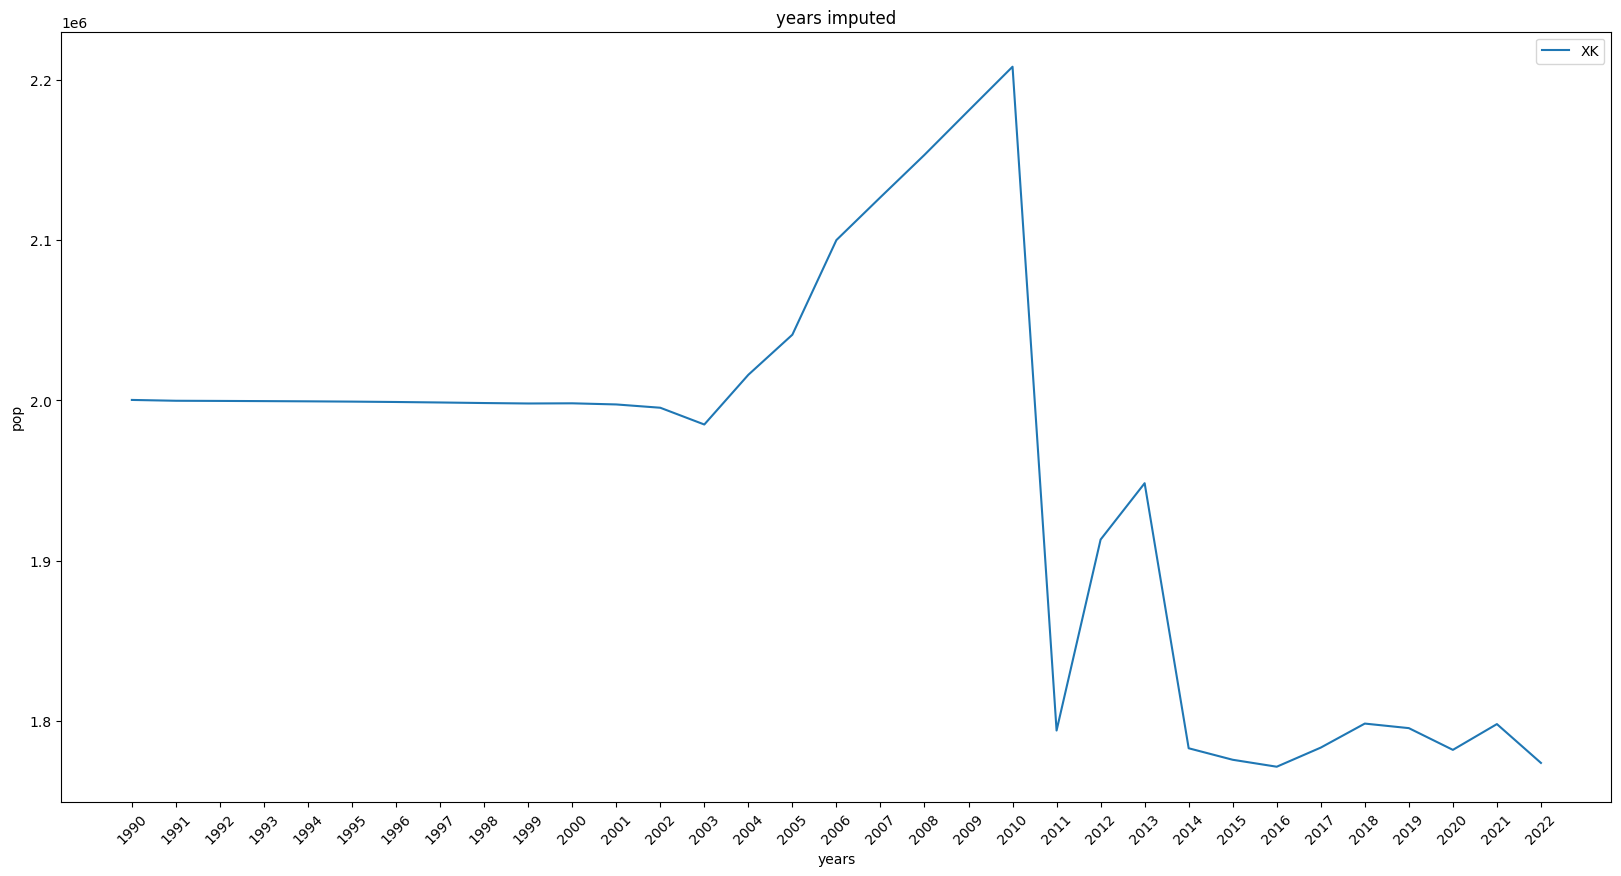

In [16]:
years = data_pop_imputed[is_COUNTRY].columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
# fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
# colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row in data_pop_imputed[is_COUNTRY].values:
    plt.plot(years, row[1:], label=row[0])

# plt.subplot(1, 2, 1)
plt.ylabel('pop')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('years imputed')
plt.legend();

In [17]:
what_is('RA120')

'type: siec --> RA120: Mixed hydro power'

In [18]:
pd.set_option('display.max_columns', 100) #default 20

In [19]:
not_in_energy = []
for geo in data_pop_all['geo']:
    if  what_is(geo)[-6:] == 'exsist':
        not_in_energy.append(geo)

In [20]:
for name in not_in_energy:
    data_pop_all = data_pop_all.drop(data_pop_all[data_pop_all['geo'] == name].index)

In [21]:

import numpy as np
is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
is_SI = data_other['geo'] == 'DE'
is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
data_other.loc[condition].drop([str(year) for year in range(1990, 2021)], axis=1).drop("2022", axis=1)

,freq,siec,plant_tec,operator,unit,geo,2021
44,A,CF,CAP_NET_ELC,PRR_MAIN,MW,DE,88178.0
266,A,N9000,CAP_NET_ELC,PRR_MAIN,MW,DE,8113.0
488,A,RA100,CAP_NET_ELC,PRR_MAIN,MW,DE,10809.0
562,A,RA110,CAP_NET_ELC,PRR_MAIN,MW,DE,4321.0
784,A,RA120,CAP_NET_ELC,PRR_MAIN,MW,DE,1134.0
1006,A,RA130,CAP_NET_ELC,PRR_MAIN,MW,DE,5354.0
1228,A,RA200,CAP_NET_ELC,PRR_MAIN,MW,DE,46.0
1450,A,RA300,CAP_NET_ELC,PRR_MAIN,MW,DE,63711.0
1524,A,RA310,CAP_NET_ELC,PRR_MAIN,MW,DE,0.0
1746,A,RA320,CAP_NET_ELC,PRR_MAIN,MW,DE,0.0


In [22]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [23]:


# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [24]:
siec_not_to_include = {'RA110','RA120','RA130','RA310','RA320','RA410','RA420','RA420AC',
                       'RA420DC','R5210P','R5220P','R5290','R5300','RA110ROR','RA420KW20-1000',
                       'RA420KW30-1000','RA420KW30-1000_OG','RA420KW30-1000_RT','RA420KW_LT10',
                       'RA420KW_LT20','RA420KW_LT30','RA420KW_LT30_OG','RA420KW_LT30_RT','RA420MW_GT1',
                       'RA420MW_GT1_OG','RA420MW_GT1_RT','RA420OG','W6000','W6100','W6200','TOTAL'}

1. Za vsak tip proizvodnje energije katera država najbolj proizvaja omenjeno energijo

In [25]:
SIEC = data_combined['siec'] == None
for siec in siec_not_to_include:
    SIEC = np.logical_or(SIEC, data_combined['siec'] == siec)
SIEC = np.negative(SIEC)
GEO = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')
condition = np.logical_and(SIEC, GEO)

In [26]:
data_combined_2022 = data_combined.loc[condition].drop([str(year) for year in range(1990, 2021)], axis=1).reset_index().drop('index', axis=1).drop("2022", axis=1)

In [27]:
data_pop_2022 = data_pop_imputed.drop([str(year) for year in range(1990, 2021)], axis=1)
GEO = data_pop_2022['geo'] == None
for country in np.unique(data_combined_2022['geo']):
    GEO = np.logical_or(GEO, data_pop_2022['geo'] == country)
data_pop_2022 = data_pop_2022.loc[GEO].reset_index().drop('index', axis=1)

In [28]:
a = pd.DataFrame(data_pop_2022['2022'].to_numpy().reshape(1, 35))
asd = a.reindex(['2021'], columns=np.unique(data_pop_2022['geo']))

In [29]:
for bCol, aCol in zip(asd.keys(), a.keys()):
    asd[bCol] = list(a[aCol])
asd

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
2021,2793592.0,8978929.0,3.841156e+06,11617623.0,6838937.0,904705.0,10516707.0,83237124.0,5873420.0,1331796.0,10459782.0,47432893.0,5548241.0,67871925.0,3862305.0,9689010.0,5060004.0,59030133.0,39308.0,2805998.0,645397.0,1875757.0,617683.0,1837114.0,520971.0,17590672.0,5425270.0,36889761.0,10352042.0,19042455.0,6797105.0,10452326.0,2107180.0,5434712.0,84680273.0


In [30]:
a = pd.DataFrame(data_combined_2022['2021'].to_numpy().reshape(9, 35))
b = a.reindex(labels=np.unique(data_combined_2022['siec']), columns=np.unique(data_combined_2022['geo']))

In [31]:
for bCol, aCol in zip(b.keys(), a.keys()):
    b[bCol] = list(a[aCol])
(np.sum(b['BG']) * 1000 * 24) / asd['BG']

2021    38.782087
Name: BG, dtype: float64

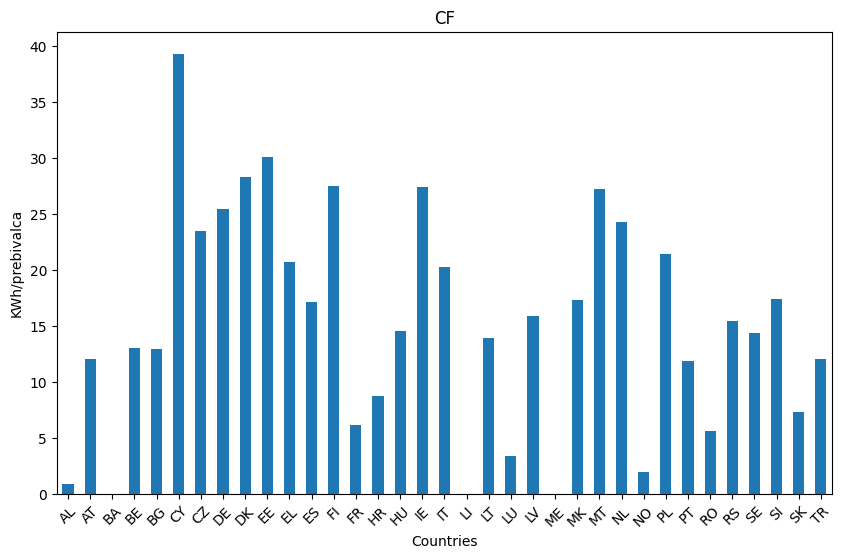

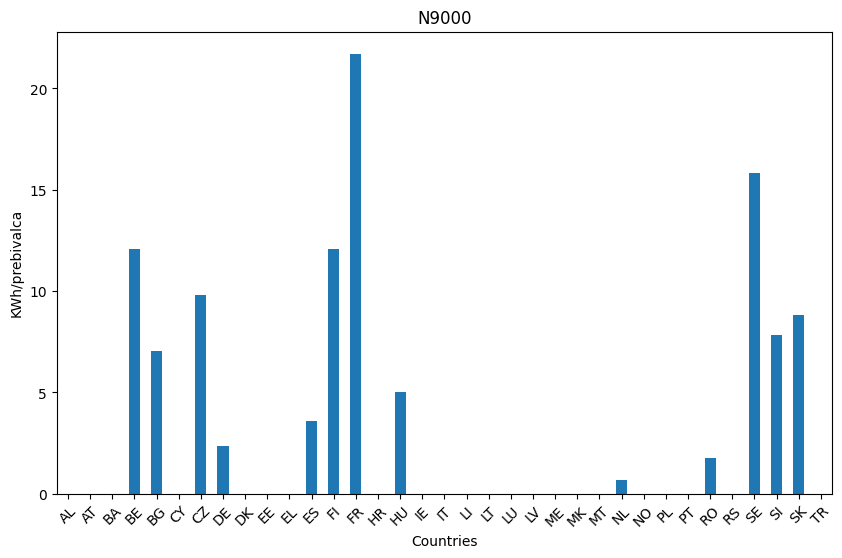

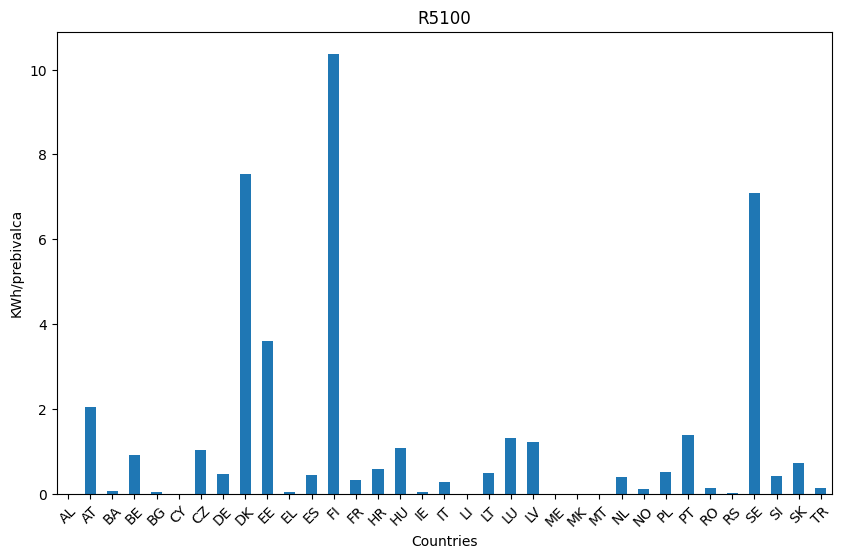

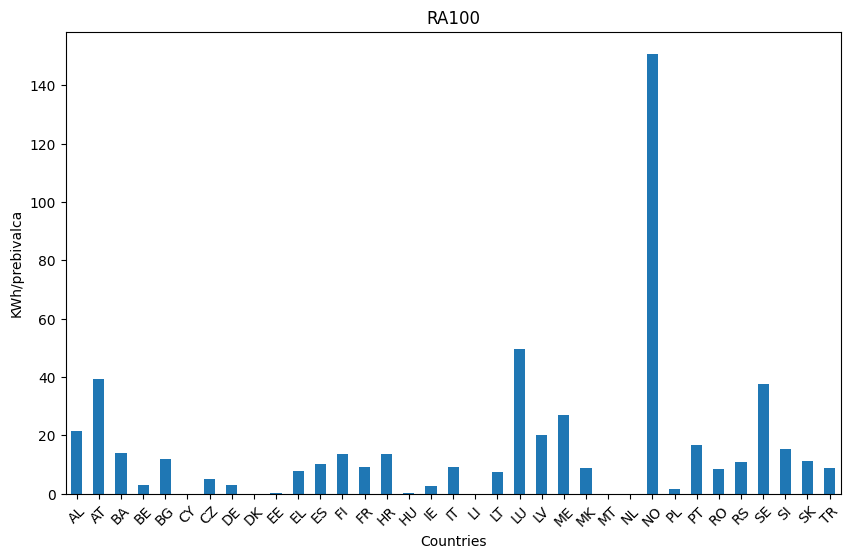

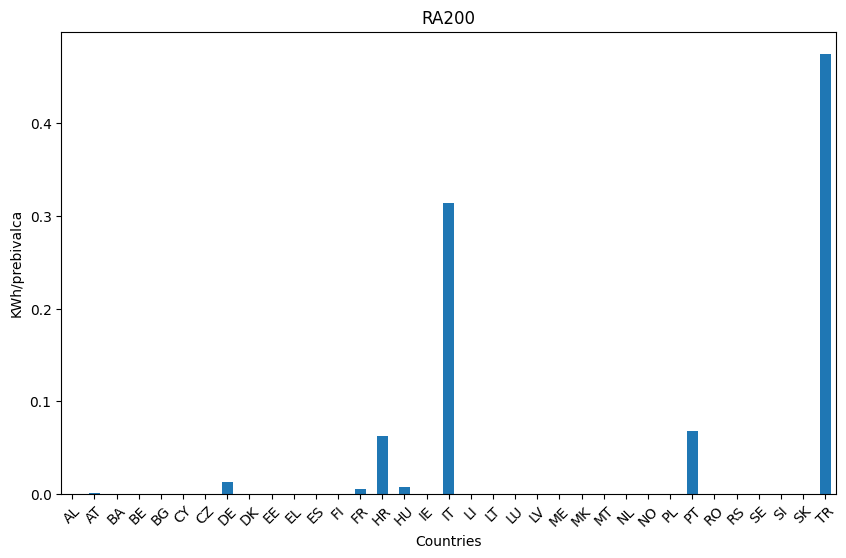

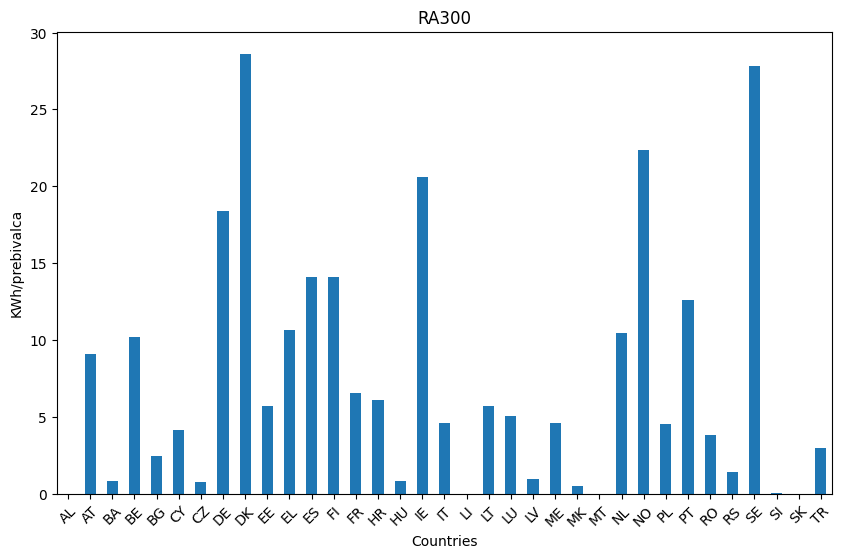

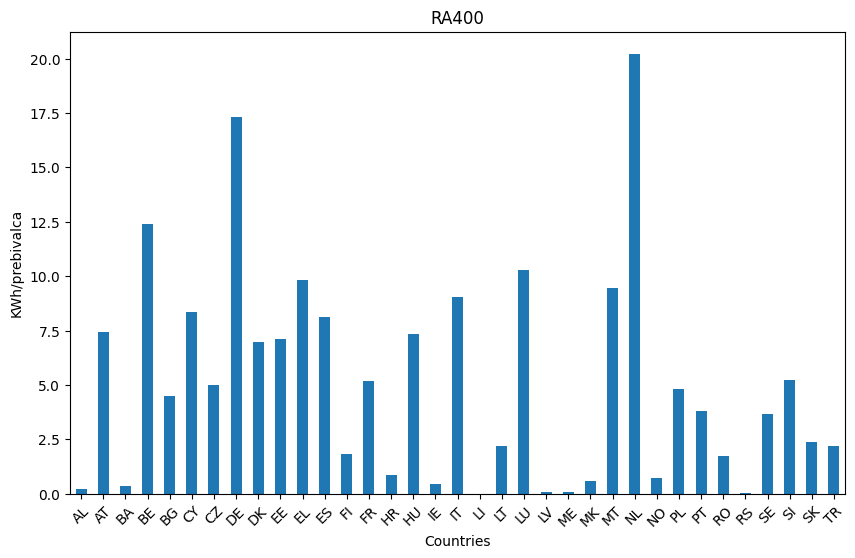

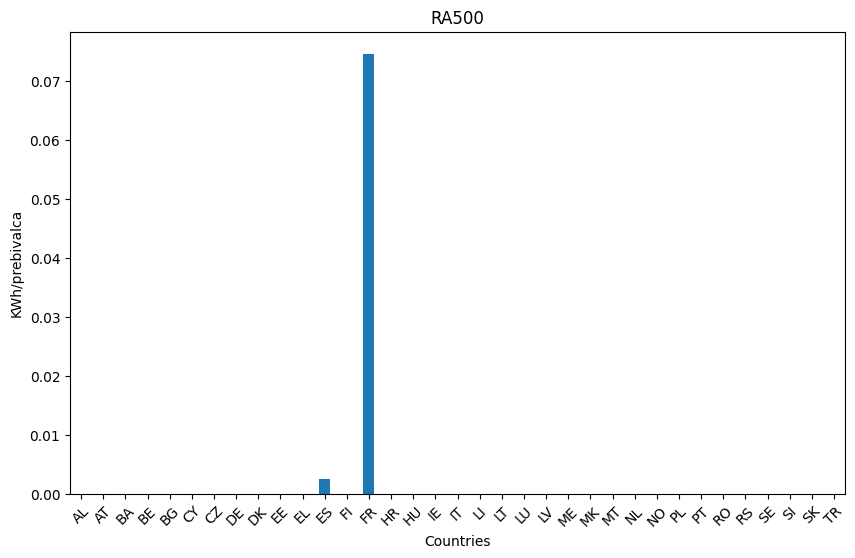

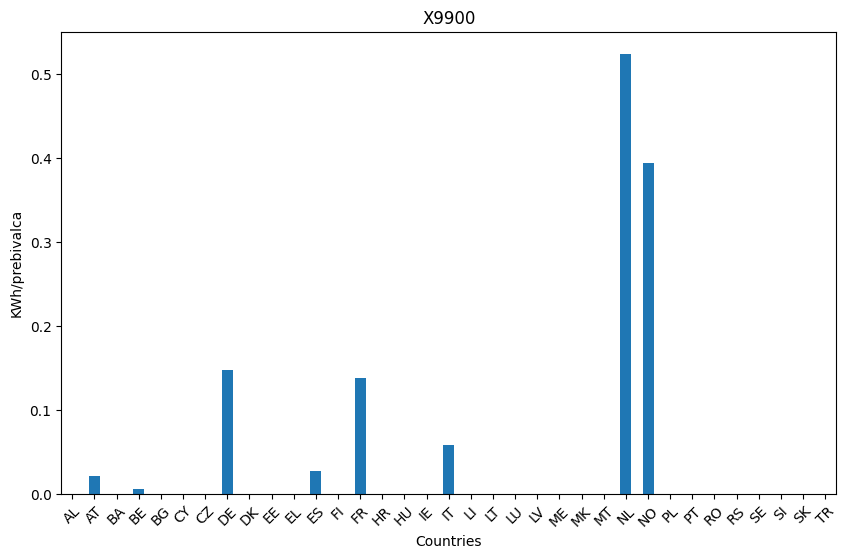

In [52]:
for energy_type in b.index:
    row_data = b.loc[energy_type]

    plt.figure(figsize=(10, 6))
    row_data.plot(kind='bar')

    plt.title(f"{energy_type}")
    plt.xlabel("Countries")
    plt.ylabel("KWh/prebivalca")
    plt.xticks(rotation=45)

    plt.show()

In [32]:
b

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
CF,98.0,4510.148,NaN,6282.0,3682.936,1480.436,10269.351,88178.0,6909.611,1670.00,9013.520,33848.721,6355.0,17428.468,1399.7,5875.0,5768.000,49765.700,0.0,1625.0,89.976,1239.282,NaN,1321.60,590.000,17771.767,439.000,32937.214,5098.362,4462.615,4357.525,6265.0,1528.811,1658.0,42457.367
N9000,0.0,0.000,NaN,5851.0,2006.000,0.000,4290.000,8113.0,0.000,0.00,0.000,7117.290,2794.0,61400.000,0.0,2027.0,0.000,0.000,0.0,0.0,0.000,0.000,NaN,0.00,0.000,512.000,0.000,0.000,0.000,1411.300,0.000,6899.0,688.000,2003.0,0.000
R5100,0.0,764.702,9.22,448.0,13.914,0.000,456.000,1587.0,1847.796,200.00,16.109,867.182,2398.0,898.840,95.3,438.0,6.707,702.464,0.0,58.0,35.145,94.720,0.000,0.00,0.000,284.191,27.000,803.185,602.968,108.771,2.400,3093.0,36.000,163.0,490.958
RA100,2507.0,14747.928,2256.78,1417.7,3369.239,0.000,2284.863,10844.0,7.123,6.00,3421.000,20132.368,3171.0,25990.796,2200.5,60.0,529.000,22749.660,0.0,877.0,1330.527,1587.230,696.685,689.19,0.000,37.700,34075.000,2397.548,7254.902,6662.197,3084.992,16407.0,1352.063,2531.0,31492.578
RA200,0.0,0.250,0.00,0.0,0.000,0.000,0.000,46.0,0.000,0.00,0.000,0.000,0.0,16.150,10.0,3.0,0.000,771.790,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,29.100,0.050,0.000,0.0,0.000,0.0,1676.170
RA300,0.0,3407.811,135.00,4948.4,704.375,157.500,339.414,63711.0,7003.948,316.00,4649.130,27907.651,3257.0,18551.121,986.9,324.0,4339.041,11253.733,0.0,671.0,136.444,77.129,118.000,36.80,0.100,7673.805,5049.000,6967.339,5427.326,3014.958,398.000,12116.0,3.328,4.0,10606.975
RA400,23.0,2782.602,56.51,6012.4,1274.713,314.523,2190.958,60038.0,1704.041,394.77,4277.420,16019.208,425.0,14603.172,138.3,2968.0,92.431,22280.951,0.0,255.0,277.161,7.155,2.570,45.20,205.473,14822.880,167.593,7415.518,1645.994,1393.922,12.128,1606.0,461.164,537.0,7815.630
RA500,0.0,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.000,4.796,0.0,211.192,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000
X9900,0.0,8.000,NaN,2.5,0.000,0.000,0.000,511.0,0.000,0.00,0.000,54.095,0.0,388.789,0.0,0.0,0.000,142.428,0.0,0.0,0.000,0.000,NaN,0.00,0.000,384.000,89.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000


In [33]:
what_is('BE')

'type: geo --> BE: Belgium'

In [34]:
for x in b.keys():
    b[x] = b[x].values * 24 * 1000 / np.repeat(asd[x].values, len(b[x]))

In [45]:
np.sum(b['HR']), np.sum(b['SI'])

(30.01751544738181, 46.34857202517108)

In [36]:
b

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
CF,0.841927,12.055285,NaN,12.977526,12.924591,39.272983,23.435513,25.424617,28.234089,30.094699,20.681548,17.126708,27.489794,6.162831,8.697604,14.552570,27.358081,20.233341,0.0,13.898798,3.345885,15.856408,NaN,17.265341,27.180016,24.247079,1.942023,21.428524,11.819957,5.624420,15.386050,14.385315,17.412591,7.321823,12.033225
N9000,0.000000,0.000000,NaN,12.087154,7.039691,0.000000,9.790137,2.339245,0.000000,0.000000,0.000000,3.601192,12.085993,21.711481,0.000000,5.020946,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.698552,0.000000,0.000000,0.000000,1.778720,0.000000,15.841067,7.836065,8.845363,0.000000
R5100,0.000000,2.043991,0.057608,0.925491,0.048829,0.000000,1.040630,0.457584,7.550474,3.604156,0.036962,0.438775,10.373017,0.317836,0.592185,1.084941,0.031812,0.285602,0.0,0.496080,1.306917,1.211927,0.000000,0.000000,0.000000,0.387739,0.119441,0.522542,1.397911,0.137089,0.008474,7.101960,0.410027,0.719817,0.139147
RA100,21.537862,39.420099,14.100631,2.928723,11.823729,0.000000,5.214247,3.126682,0.029106,0.108125,7.849494,10.186535,13.716780,9.190532,13.673700,0.148622,2.509089,9.249375,0.0,7.501074,49.477528,20.308345,27.069613,9.003557,0.000000,0.051436,150.739042,1.559814,16.819643,8.396645,10.892845,37.672763,15.399497,11.177041,8.925596
RA200,0.000000,0.000668,0.000000,0.000000,0.000000,0.000000,0.000000,0.013263,0.000000,0.000000,0.000000,0.000000,0.000000,0.005711,0.062139,0.007431,0.000000,0.313788,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067465,0.000063,0.000000,0.000000,0.000000,0.000000,0.475058
RA300,0.000000,9.108822,0.843496,10.222539,2.471875,4.178158,0.774571,18.369976,28.619570,5.694566,10.667442,14.120657,14.088790,6.559810,6.132504,0.802559,20.580415,4.575453,0.0,5.739135,5.073863,0.986853,4.584876,0.480754,0.004607,10.469829,22.335478,4.532860,12.582621,3.799877,1.405304,27.820028,0.037905,0.017664,3.006218
RA400,0.197595,7.437685,0.353081,12.420579,4.473372,8.343661,4.999948,17.310930,6.963061,7.114063,9.814553,8.105367,1.838421,5.163786,0.859383,7.351835,0.438408,9.058811,0.0,2.181042,10.306624,0.091547,0.099857,0.590491,9.465694,20.223737,0.741388,4.824440,3.816045,1.756818,0.042823,3.687600,5.252487,2.371423,2.215098
RA500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002427,0.000000,0.074679,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
X9900,0.000000,0.021383,NaN,0.005165,0.000000,0.000000,0.000000,0.147338,0.000000,0.000000,0.000000,0.027371,0.000000,0.137479,0.000000,0.000000,0.000000,0.057907,0.0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.523914,0.393713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
what_is('R5100')

'type: siec --> R5100: Solid biofuels'

In [38]:
(np.sum(b['DE']) * 1000 / 365 * 24) * 24 * 365 

38701229.89833238

In [39]:
what_is('MW')

'type: unit --> MW: Megawatt'

3. Keri tip energije proizvaja največ elektrike v evropi

In [40]:
####   filtriranje data setov

# # is_PRODUCING = data_renewables['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_renewables['siec'] != 'TOTAL'
# is_ACTIVE = data_renewables['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_renewables['geo'] != 'EA20', data_renewables['geo'] != 'EU27_2020')
# for country in countries_only_in_renewables:
#     is_GEO = np.logical_and(is_GEO, data_renewables['geo'] != country)
# condition = np.logical_and(is_GEO, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# # condition = np.logical_and(condition, is_GEO)
# condition_2 = condition
# # data_renewables.loc[condition]

# is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_other['siec'] != 'TOTAL'
# is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_other['geo'] != 'EA20', data_other['geo'] != 'EU27_2020')
# condition = np.logical_and(is_PRODUCING, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# condition = np.logical_and(condition, is_GEO)
# condition_1 = condition
# # data_other.loc[condition]

condition_combined = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')

In [41]:
####  ustvarjanje zdruzenega dataseta

dictNeki = {}
dictNeki['siec'] = []
for year in data_combined.keys()[2:]:
    dictNeki[year] = []

for siec in np.unique(data_combined['siec']):
    if siec in siec_not_to_include:
        continue
    dictNeki['siec'].append(siec)
    con = np.logical_and(data_combined['siec'] == siec, condition_combined)
    for year in data_combined.keys()[2:]:
        dictNeki[year].append(np.sum(data_combined.loc[con][year])) 
    
# for siec in np.unique(data_renewables['siec']):
#     if siec in siec_not_to_include:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_renewables['siec'] == siec, condition_2)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_renewables.loc[con][str(year)]))


# for siec in np.unique(data_other['siec']):
#     if siec in siec_not_to_include or siec in dictNeki['siec']:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_other['siec'] == siec, condition_1)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_other.loc[con][str(year)]))
    
vsota_energij_po_vrsti = pd.DataFrame(dictNeki)

In [42]:
vsota_energij_po_vrsti = vsota_energij_po_vrsti.sort_values('siec')
vsota_energij_po_vrsti

,siec,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,CF,235565.000,252358.000,255609.000,257903.000,259559.550,267870.350,272918.350,276630.550,280427.550,289130.550,306312.412,308237.633,313232.633,312819.583,320702.492,330497.118,338485.646,344841.034,350068.028,357109.177,370134.056,409099.783,416520.530,414216.652,417478.044,407882.962,400412.277,395786.297,401302.616,393581.872,386574.460,374376.110,375806.719
1,N9000,110267.000,111444.000,113162.000,114559.000,114225.000,116223.000,117837.000,120175.000,123099.000,124657.000,124851.000,124882.000,126297.000,125416.000,124555.000,123142.000,122837.000,121850.000,122152.000,121684.000,120866.000,121424.000,113237.000,113065.000,113578.000,112497.000,112581.000,111550.590,111266.590,109980.590,106034.590,105111.590,100199.590
2,R5100,3028.000,3081.000,3409.000,3515.000,3727.000,3931.595,4169.396,4063.681,4069.777,4528.246,5265.461,5694.041,5963.134,6977.887,7510.942,9391.990,10510.780,10221.852,11005.763,11935.317,12683.326,13302.658,13546.365,13211.156,14101.276,14299.223,14421.788,15148.744,15724.302,15437.135,15419.189,16548.572,17371.606
3,RA100,156948.000,158355.000,161279.000,163557.000,165170.000,171909.723,173322.723,174386.723,174821.723,176664.723,178813.023,179192.797,180374.797,181212.797,183271.923,186238.998,186818.107,188174.200,189622.961,191752.501,194087.561,197077.536,200878.905,205326.253,207060.033,211572.345,214482.437,218188.623,219918.509,220922.125,224874.256,226170.569,227822.465
4,RA200,517.000,590.000,494.000,494.000,498.000,498.000,513.000,557.000,577.000,617.000,622.000,605.000,700.000,738.000,673.000,700.915,719.915,722.915,729.915,803.915,854.915,888.815,945.415,1106.915,1242.915,1461.665,1663.074,1912.105,2143.923,2381.093,2484.193,2552.510,2571.628
5,RA300,443.981,613.859,812.449,1073.599,1476.737,2233.999,3119.721,4237.547,5907.682,8724.645,12329.515,16876.953,22720.631,27367.316,33316.737,39046.480,45929.090,53909.798,60870.284,72067.527,80682.009,89647.530,100111.041,109209.385,120144.961,132580.551,144662.597,156769.235,166314.664,178285.058,190573.922,204292.228,220700.522
6,RA400,11.000,12.000,28.000,36.000,41.000,52.000,67.000,86.000,104.000,128.000,182.072,279.284,360.748,595.459,1301.974,2274.187,3230.924,4974.133,10373.182,16999.366,30616.219,53288.952,71045.230,79715.838,83680.042,87960.179,92360.983,99691.852,109180.973,126284.433,145174.166,172266.387,215586.314
7,RA500,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,213.000,215.000,218.000,219.000,218.000,216.000,215.000,215.000,218.000,216.000,216.000,215.022,216.205,223.284,225.804,223.125,225.020,224.066,223.198,218.863,216.561,215.988,216.866
8,X9900,15.000,15.000,19.000,23.000,37.450,46.650,53.650,64.450,64.450,64.450,208.450,142.450,155.450,373.450,194.450,302.450,389.450,370.450,382.450,421.795,445.295,441.295,442.295,439.295,470.295,844.595,860.595,903.969,888.758,1535.416,1203.463,1579.812,3351.799


In [43]:
np.sum(vsota_energij_po_vrsti['2022'])/1000/1000

1.1636275090000001

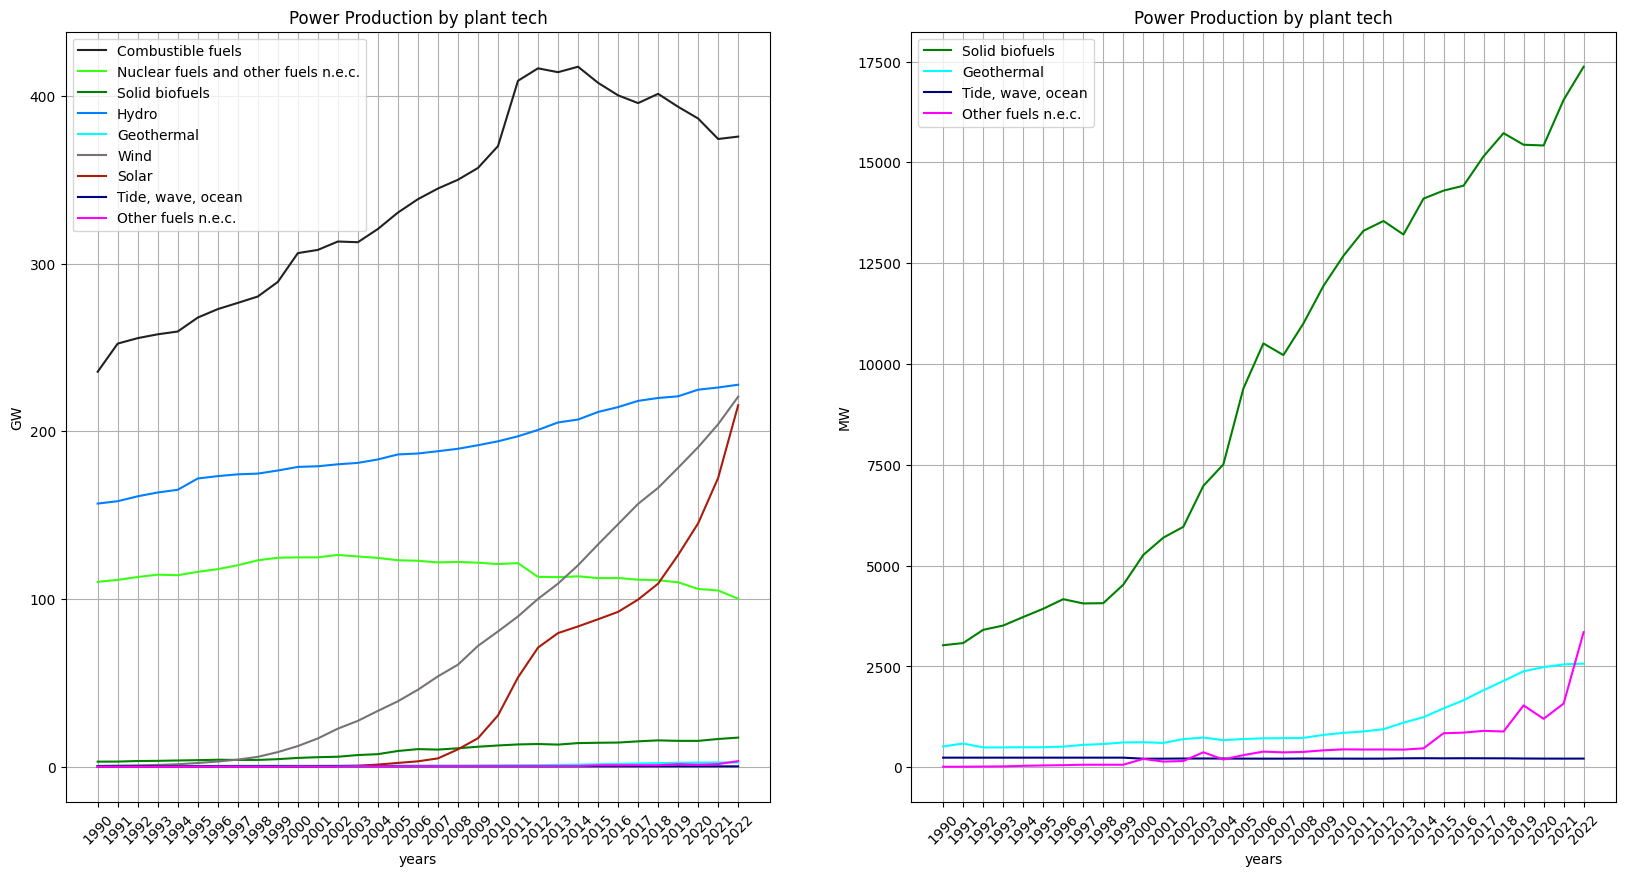

In [44]:
years = vsota_energij_po_vrsti.columns.tolist()[1:]

# vsota_energij_po_vrsti.plot(x='1990', y='1992')
fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row, colour in zip(vsota_energij_po_vrsti.values, colors):
    if row[0] in fig2:
        plt.subplot(1, 2, 2)
        plt.plot(years, row[1:], label=what_is(row[0], short=True), color=colour)
    plt.subplot(1, 2, 1)
    plt.plot(years, [power / 1000 for power in row[1:]], label=what_is(row[0], short=True), color=colour)

plt.subplot(1, 2, 1)
plt.ylabel('GW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()
